In [2]:
import pickle
import pandas as pd
import spacy
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
from essay_evaluation.classifier import Classifier
from essay_evaluation.corpus import read_csv
from essay_evaluation.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

## 1. Set paths

In [5]:
dataset_path = '/usr/local/datasets/flip_new.csv'
model_regressor_path = '/usr/local/models/model_reg.pkl'
model_classifier_path = '/usr/local/models/model_clf.pkl'
test_size = 98

## 2. Get scores for all documents
We first calculate the essay's score once, so we can compare how the essay improves/worsens when removing sentences.

In [6]:
with open(model_regressor_path, 'rb') as fh:
    model_regressor = pickle.load(fh)
with open(model_classifier_path, 'rb') as fh:
    model_classifier = pickle.load(fh)
    
pipeline = Pipeline().lexical_variation_taaled().get_pipe()
# it would be nice if the classifier would be part of our Pipeline class. But it's not that simple because it has to 
# be the _last_ component
pipeline.add_pipe(Classifier(model_regressor, 'score_regression'), name=Classifier.name + 'reg', last=True)
pipeline.add_pipe(Classifier(model_classifier, 'score_classification'), name=Classifier.name + 'clf', last=True)

texts, _= read_csv(dataset_path)
texts = texts[:test_size]
docs = list(tqdm_notebook(pipeline.pipe(texts[:test_size]), total=len(texts)))

## Predict grades for essays unchanged

In [18]:
texts = pd.read_csv(dataset_path)['Essay'][:98]
print(np.nan)
regression_grades = []
classification_grades = []
feature_matrix = []
for text in tqdm_notebook(texts):
    try:
        feature_matrix.append(list(pipeline(text)._.features.values()))
    except Exception as e:
        feature_matrix.append([])


nan


In [25]:
for features in tqdm_notebook(feature_matrix):
    if len(features) != 0:
        regression_grades.append(model_regressor.predict([features]))
        classification_grades.append(model_classifier.predict([features]))
    else:
        regression_grades.append(np.nan)
        classification_grades.append(np.nan)

np.save("original_regression_grades_test_sample.npy", np.array(regression_grades))
np.save("original_classification_grades_test_sample.npy", np.array(classification_grades))

In [21]:
sent_indicies = np.load("sent_indicies.npy", allow_pickle=True)[:98]
final_regression_orig_arr = []
final_classification_orig_arr = []
for idx, essay in tqdm_notebook(enumerate(sent_indicies)):
    
    final_regression_orig_arr += list(np.full(len(essay), regression_grades[idx]))
    final_classification_orig_arr += list(np.full(len(essay), classification_grades[idx]))

In [22]:
len(final_classification_orig_arr) == len(final_regression_orig_arr)
type(final_classification_orig_arr[23])

numpy.float64

In [23]:
original_grades_df = pd.DataFrame(None, columns=['Original Regression Grade', 'Original Classification Grade'])

assert(len(final_classification_orig_arr) == len(final_regression_orig_arr))
for idx, grade in tqdm_notebook(enumerate(final_regression_orig_arr)):
    original_grades_df.loc[len(original_grades_df)] = [grade, final_classification_orig_arr[idx]]

In [24]:
original_grades_df.to_csv("original_model_grades_test_sample.csv")
original_grades_df

,Original Regression Grade,Original Classification Grade
0,2.45,3.0
1,2.45,3.0
2,2.45,3.0
3,2.45,3.0
4,2.45,3.0
...,...,...
9042,8.00,8.0
9043,8.00,8.0
9044,8.00,8.0
9045,8.00,8.0


## Feature matrix extracted by external script found in bin/extract_score_mutated_essays.py

In [7]:
features_path = "feature_matrix.npy"
feature_matrix = np.load(features_path, allow_pickle=True)
feature_matrix.shape
feature_matrix = feature_matrix[:98]

## Get regression and Classification Grade

In [7]:
regression_grades = []
classification_grades = []

for row in tqdm_notebook(feature_matrix):
    if row != []:
        regression_grades.append(model_regressor.predict(row))
        classification_grades.append(model_classifier.predict(row))
    else:
        regression_grades.append([])
        classification_grades.append([])

In [15]:
df = pd.DataFrame(None, columns=['Removed Phrase number', 'Sentence number', 'Essay number', 'Regression Grade', 'Classification Grade', 'Original Grade'])
clause_indicies = np.load("clause_indicies.npy", allow_pickle=True)[:98]
sent_indicies = np.load("sent_indicies.npy", allow_pickle=True)[:98]
original_grades = list(pd.read_csv(dataset_path)["Level"])[:98]

for idx, og in tqdm_notebook(enumerate(original_grades)):
    for clause_idx, clause_num in enumerate(clause_indicies[idx]):
        df.loc[len(df)] = [clause_num, sent_indicies[idx][clause_idx],
                           idx, regression_grades[idx][clause_idx],
                           classification_grades[idx][clause_idx], og]

In [16]:
df.to_csv("final_data_test_samples.csv")

In [17]:
len(df)

9047

## Parse and produce essays for each clause

## Visualizing some data

In [10]:
texts, _= read_csv(dataset_path)
texts = texts[:98]
docs = list(tqdm_notebook(pipeline.pipe(texts), total=len(texts)))

In [11]:
sent_length = []
for doc in docs:
    text = []
    for sent in doc.sents:
        text.append(len(sent))
        
    sent_length.append(text)

from collections import Counter
statistics_counter = Counter()
for row in sent_length:
    for cnt in row:
        statistics_counter[cnt] += 1

<h3>Some statistics on the lenght of the sentences</h3>
<h4>As can be seen, splitting on a fixed number of 6 is possible and also easy so that is what will be done, those sentences who can not be split on at least two groups of 6 will be ignored.</h4>

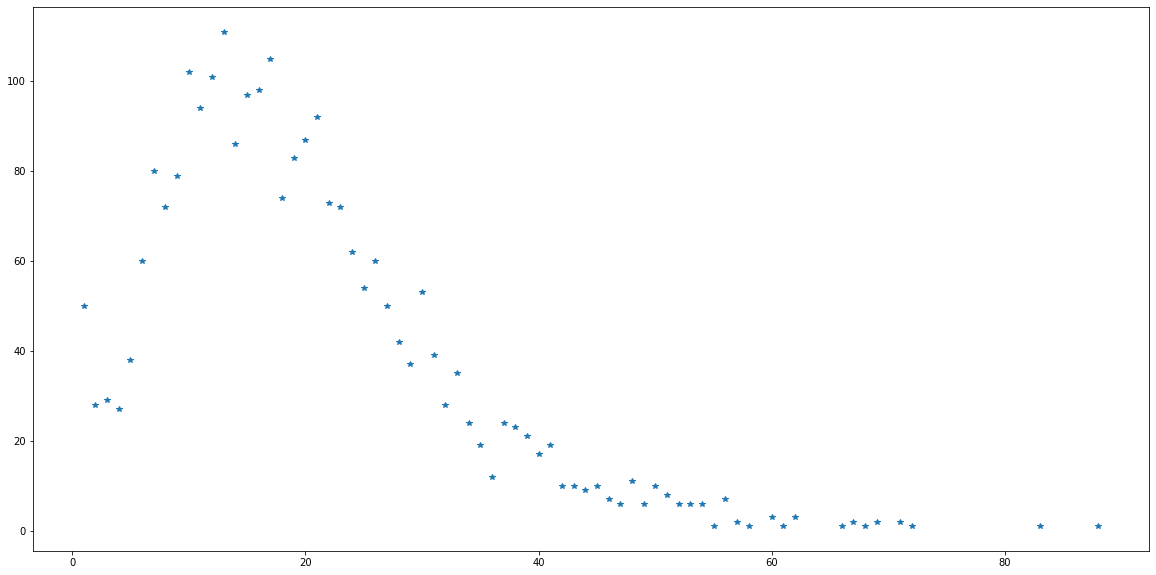

In [12]:
plt.rcParams["figure.figsize"] = (20, 10)
plt.plot(list(statistics_counter.keys()), list(statistics_counter.values()), '*')

## Create a matrix of mutated essays

In [13]:
token = docs[0][1]
sent = docs[0].sents
print(sent)
for sent in docs[0].sents:
    print(' '.join([str(token) for idx, token in enumerate(sent) if idx <= 6]))
    break
int(max(statistics_counter.keys())/6)

I think basketball and tabletennis are popular


14

In [15]:
mutated_essays  = []
clause_indecies = []
sent_indicies   = []

for doc in tqdm_notebook(docs):
    row_mutated_essays = []
    list_sents = list(doc.sents)
    
    temp_sent_indicies = []
    temp_clause_indicies = []
    for idx, sent in enumerate(doc.sents):
        temp_sents = []
        temp_sent = ""
        #create partial sentences
        if len(sent) < 6:
            temp_sent_indicies.append(idx)
            temp_clause_indicies.append(-1)
            continue
        else:
            num_subgroups = int(len(sent)/6)
            if len(sent)%6 != 0:
                num_subgroups += 1
                
            for sub_group in np.arange(num_subgroups):
                temp_sent = ' '.join([str(token) for idx, token in enumerate(sent) if idx >= 6*sub_group and idx < 6*(sub_group+1)])
                temp_sents.append(temp_sent)
                
                temp_sent_indicies.append(idx)
                temp_clause_indicies.append(sub_group)
                
                if sub_group != num_subgroups-1:
                    temp_sents[-1] += '.' #add a dot to the end of the sentence
        #mutate essay
        for temp_sent in temp_sents:
            sents = []
            for sent in doc.sents:
                sents.append(str(sent))
            sents[idx] = temp_sent
            row_mutated_essays.append(''.join(sents))
            
    assert(len(temp_sent_indicies) == len(temp_clause_indicies))
    sent_indicies.append(temp_sent_indicies)
    clause_indecies.append(temp_clause_indicies)        
    mutated_essays.append(row_mutated_essays)
    


In [16]:
sent_indicies

[[0, 0, 1, 1, 2, 2, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5, 6, 6, 7, 7, 8, 8, 8, 8],
 [0,
  1,
  2,
  2,
  2,
  3,
  4,
  4,
  5,
  6,
  6,
  6,
  6,
  6,
  7,
  7,
  7,
  7,
  8,
  8,
  8,
  8,
  8,
  8,
  9,
  9,
  9,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  11,
  12,
  13,
  13,
  13,
  13,
  13,
  13,
  14,
  14,
  14,
  14,
  14,
  15,
  15,
  15,
  16,
  16,
  16,
  16,
  17,
  17,
  17,
  17,
  17,
  17,
  17,
  17,
  17,
  17],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  3,
  3,
  4,
  4,
  5,
  5,
  6,
  6,
  6,
  6,
  7,
  7,
  8,
  8,
  8,
  8,
  8,
  8,
  9,
  9,
  9,
  9,
  10,
  10,
  10,
  10,
  10,
  11,
  11,
  11,
  11,
  12,
  12,
  12,
  12,
  12],
 [0,
  0,
  1,
  1,
  2,
  3,
  3,
  4,
  4,
  5,
  5,
  6,
  6,
  7,
  7,
  8,
  8,
  9,
  10,
  10,
  11,
  12,
  12,
  13,
  13,
  14,
  14,
  14,
  15,
  15,
  16,
  16,
  17,
  17,
  18,
  18,
  18,
  19,
  19,
  20,
  20,
  20,
  21,
  21,
  21,
  22,
  22,
  22,
  22,
  23,
  23,
  24,
  

In [143]:
mutated_essays_np = np.array(mutated_essays)
np.save('mutated_essays.npy', mutated_essays_np)

In [146]:
test = np.load('mutated_essays.npy', allow_pickle=True)
test[0][0]

"I think basketball and tabletennis are.Baseball and american football are not popular in my country.Baseball is our national sport in Taiwan.I usually like jogging and I used to be in the school football team, but I used to play baseketball more often in my highschool.Besides, I also play table tennis very well.I don't have my favorite sport, I think every sport has its benefits.I like jogging, I can improve my endurance by jogging.I can improve my flexibility by playing basketball and table tennis.We should not only do one kind of exercise, we should do many different kind of exercise."

In [150]:
sent_indicies_np = np.array(sent_indicies)
clause_indecies = np.array(clause_indecies)
np.save('sent_indicies.npy', sent_indicies_np)
np.save('clause_indicies.npy', clause_indecies)

## Sanity check

In [139]:
assert(len(mutated_essays) == len(sent_indicies) == len(clause_indecies))
for idx in range(len(mutated_essays)):
    assert(len(mutated_essays[idx]) == len(sent_indicies[idx]) == len(clause_indecies[idx]))